In [1]:
pip install onnx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [3]:
pip install numba

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install numba

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
from numba import cuda
print(cuda.detect())


Found 1 CUDA devices
id 0      b'NVIDIA T400 4GB'                              [SUPPORTED]
                      Compute Capability: 7.5
                           PCI Device ID: 0
                              PCI Bus ID: 1
                                    UUID: GPU-f748cbed-5ce7-bff1-bd01-ea1a21a5bf6f
                                Watchdog: Enabled
                            Compute Mode: WDDM
             FP32/FP64 Performance Ratio: 32
Summary:
	1/1 devices are supported
True


In [3]:
import cv2

# Load image (in BGR format by default)
img = cv2.imread('pexels-magalie-parise-2147945619-32654307 (1).jpg')

# Check if image loaded correctly
if img is None:
    print("Error: Image not found or failed to load.")
else:
    print("Image shape:", img.shape)  # (Height, Width, Channels)


Image shape: (224, 224, 3)


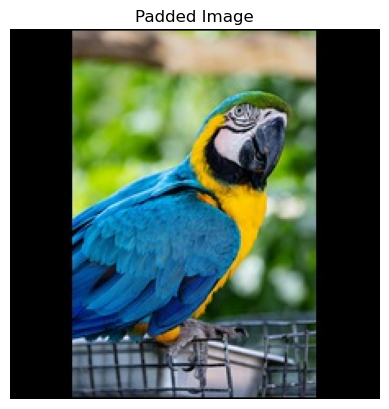

(226, 226, 3)


In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load image as RGB
img = cv2.imread('pexels-magalie-parise-2147945619-32654307 (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Apply padding: 10 pixels on each side
padded_img = np.pad(img, pad_width=((1, 1), (1, 1), (0, 0)), mode='constant', constant_values=0)

# Save the padded image
padded_bgr = cv2.cvtColor(padded_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('padded_phototrained (4).jpeg', padded_bgr)

# Display the padded image
plt.imshow(padded_img)
plt.title("Padded Image")
plt.axis("off")
plt.show()
print(padded_bgr.shape)

In [11]:
import numpy as np
import cv2

# === Step 1: Load image ===
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)
    image = image.transpose((2, 0, 1))  # (C, H, W)
    return image  # float32

# === Step 2: AbsMax Quantization to int8 ===
def absmax_quantize(image, dtype=np.int8):
    max_val = np.max(np.abs(image))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(image / scale).astype(dtype)
    return quantized, scale

# === Step 3: Save & Display ===
image_path = "padded_phototrained (4).jpeg"
input_img = load_image(image_path)
quantized_img, scale = absmax_quantize(input_img)

np.save("quantized_image_int8.npy", quantized_img)
np.save("quantized_image_scale.npy", np.array([scale]))

print("✅ Image quantized using AbsMax")
print("Scale:", scale)

# === (Optional) Visualize reconstructed image ===
def dequantize_image(quantized, scale):
    dequantized = quantized.astype(np.float32) * scale
    return dequantized.transpose(1, 2, 0).astype(np.uint8)

# Save or show the dequantized version
dequantized_image = dequantize_image(quantized_img, scale)
cv2.imwrite("dequantized_preview.jpg", cv2.cvtColor(dequantized_image, cv2.COLOR_RGB2BGR))




✅ Image quantized using AbsMax
Scale: 2.0078740157480315


True

In [12]:
import cv2

image_path = "padded_phototrained (4).jpeg"  # or any other image path
image = cv2.imread(image_path)

print("Data type:", image.dtype)           # Should be: uint8
print("Pixel range:", image.min(), image.max())  # Typically: 0 to 255
print("Shape:", image.shape)               # (H, W, 3)


Data type: uint8
Pixel range: 0 255
Shape: (226, 226, 3)


In [16]:
import numpy as np
import cv2

# === Step 1: Load and preprocess image (VGG-style) ===
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype(np.float32)
    mean = np.array([123.68, 116.779, 103.939]).reshape((3, 1, 1))
    image = image.transpose((2, 0, 1))  # (C, H, W)
    image -= mean
    return image  # float32

image_path = "padded_phototrained (4).jpeg"
input_fp32 = load_image(image_path)

# === Step 2: AbsMax Quantize the image to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

input_int8, input_scale = absmax_quantize(input_fp32, dtype=np.int8)
print("✅ Image quantized to int8 with scale:", input_scale)
print("Input int8 shape:", input_int8.shape, "| dtype:", input_int8.dtype)

np.save("quantized_image_int8.npy", input_int8)
np.save("quantized_image_scale.npy", np.array([input_scale]))


✅ Image quantized to int8 with scale: 1.1894567294383611
Input int8 shape: (3, 226, 226) | dtype: int8


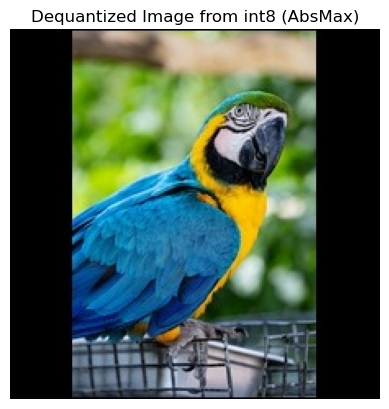

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# === Load quantized int8 image and scale ===
input_int8 = np.load("quantized_image_int8.npy")     # Shape: (3, H, W), dtype=int8
scale = np.load("quantized_image_scale.npy")[0]      # Single float from AbsMax

# === Step 1: Dequantize image ===
image_dequant = input_int8.astype(np.float32) * scale  # int8 → float32 using AbsMax

# === Step 2: Add mean back (reverse VGG preprocessing) ===
mean = np.array([123.68, 116.779, 103.939]).reshape(3, 1, 1)
image_restored = image_dequant + mean

# === Step 3: Convert CHW → HWC and clip to [0, 255] ===
image_restored = image_restored.transpose(1, 2, 0)  # (H, W, C)
image_restored = np.clip(image_restored, 0, 255).astype(np.uint8)

# === Step 4: Display the image ===
plt.imshow(image_restored)
plt.title("Dequantized Image from int8 (AbsMax)")
plt.axis("off")
plt.show()



In [20]:
import numpy as np
import cv2

# === Step 1: Load Conv1 weights from ONNX (format: (64, 3, 3, 3)) ===
conv1_weights = np.load("vgg0_conv0_weight (1).npy")  # Replace with actual filename
assert conv1_weights.shape == (64, 3, 3, 3), "❌ Conv1 weights shape mismatch"
print("✅ Loaded Conv1 weights:", conv1_weights.shape)

# === Step 2: Quantize weights to int8 using AbsMax ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv1_qweights, conv1_wscale = absmax_quantize(conv1_weights)
print("✅ Quantized weights to int8 with scale:", conv1_wscale)

# === Step 3: Load and preprocess image (VGG style) ===
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    mean = np.array([123.68, 116.779, 103.939]).reshape(3, 1, 1)
    img = img.transpose((2, 0, 1))  # (C, H, W)
    img -= mean
    return img

image_path = "padded_phototrained (4).jpeg"  # Replace with your image path
input_tensor_fp32 = load_image(image_path)  # Shape: (3, 224, 224)

# === Step 4: Quantize image to int8 using AbsMax ===
input_tensor_q, input_scale = absmax_quantize(input_tensor_fp32, dtype=np.int8)
print("✅ Quantized image to int8 with scale:", input_scale)

# === Step 5: Perform convolution (int8 × int8 → int32) ===
C_out, C_in, kH, kW = conv1_qweights.shape
H, W = input_tensor_q.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):  # 64 filters
    for c in range(C_in):  # 3 channels
        for i in range(out_H):
            for j in range(out_W):
                patch = input_tensor_q[c, i:i+kH, j:j+kW]
                kernel = conv1_qweights[f, c]
                output[f, i, j] += np.sum(patch.astype(np.int32) * kernel.astype(np.int32))

# === Step 6: Save output ===
np.save("conv1_output_int32.npy", output)
print("✅ Saved int32 output: conv1_output_int32.npy")
print("Output shape:", output.shape)


✅ Loaded Conv1 weights: (64, 3, 3, 3)
✅ Quantized weights to int8 with scale: 0.01319161456400954
✅ Quantized image to int8 with scale: 1.1894567294383611
✅ Saved int32 output: conv1_output_int32.npy
Output shape: (64, 224, 224)


In [21]:
import numpy as np

# === Step 1: Load Conv1 bias (float32) ===
conv1_bias_fp32 = np.load("vgg0_conv0_bias (1).npy")  # Shape: (64,)
assert conv1_bias_fp32.shape == (64,), "❌ Bias shape must be (64,)"
print("✅ Loaded Conv1 bias:", conv1_bias_fp32.shape)

# === Step 2: Use known quantization scales ===
scale_w = 0.01319161456400954   # ✅ From conv1_qweights quantization
scale_x = 1.1894567294383611    # ✅ From image quantization
scale_y = scale_w * scale_x     # Effective scale for bias quantization

# === Step 3: Quantize bias from FP32 to INT32 ===
bias_int32 = np.round(conv1_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Bias quantized to int32 using scale: {scale_y:.8f}")

# === Step 4: Load Conv1 int32 output from convolution ===
conv1_output = np.load("conv1_output_int32.npy")  # Shape: (64, H, W)
assert conv1_output.shape[0] == 64, "❌ Conv1 output must have 64 channels"

# === Step 5: Add quantized bias (broadcasting across H, W) ===
conv1_output_with_bias = conv1_output + bias_int32[:, np.newaxis, np.newaxis]

# === Step 6: Save final output ===
np.save("conv1_output_with_bias_int32.npy", conv1_output_with_bias)
print("✅ Conv1 output + quantized bias saved as: conv1_output_with_bias_int32.npy")
print("Output shape:", conv1_output_with_bias.shape)


✅ Loaded Conv1 bias: (64,)
✅ Bias quantized to int32 using scale: 0.01569085
✅ Conv1 output + quantized bias saved as: conv1_output_with_bias_int32.npy
Output shape: (64, 224, 224)


In [22]:
import numpy as np

# === Step 1: Load the INT32 output from Conv1 + bias ===
conv1_output_with_bias = np.load("conv1_output_with_bias_int32.npy")  # Shape: (64, 224, 224)

# === Step 2: Apply ReLU (zero out negatives) ===
relu_output = np.maximum(0, conv1_output_with_bias)

# === Step 3: Save ReLU output ===
np.save("conv1_output_relu.npy", relu_output)

# === Step 4: Print confirmation ===
print("✅ Conv1 + ReLU output saved: conv1_output_relu.npy")
print("ReLU Output shape:", relu_output.shape)


✅ Conv1 + ReLU output saved: conv1_output_relu.npy
ReLU Output shape: (64, 224, 224)


In [23]:
import numpy as np

# Load Conv1 + ReLU output
relu_output = np.load("conv1_output_relu.npy")  # Shape: (64, 224, 224)

# Apply 1-pixel padding to height and width dimensions
# Padding format: ((channels), (height), (width))
padded_output = np.pad(relu_output, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save padded output
np.save("conv1_output_relu_padded.npy", padded_output)

# Print shape for verification
print("✅ Padded output saved as 'conv1_output_relu_padded.npy'")
print("New shape:", padded_output.shape)  # Should be (64, 226, 226)


✅ Padded output saved as 'conv1_output_relu_padded.npy'
New shape: (64, 226, 226)


In [24]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv2 weights ===
conv2_weights = np.load("vgg0_conv1_weight.npy")  # Shape: (64, 64, 3, 3)
assert conv2_weights.shape == (64, 64, 3, 3), "❌ Invalid shape for Conv2 weights"
print("✅ Loaded Conv2 weights:", conv2_weights.shape)

# === Step 2: Quantize Conv2 weights using AbsMax ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv2_qweights, conv2_scale = absmax_quantize(conv2_weights)
print("✅ Quantized Conv2 weights to int8 with scale:", conv2_scale)

# === Step 3: Load Conv1 padded output (already int32) ===
input_tensor = np.load("conv1_output_relu_padded.npy")
assert input_tensor.shape == (64, 226, 226), "❌ Input must be shape (64, 226, 226)"
print("✅ Loaded padded input:", input_tensor.shape)

# === Step 4: Manual convolution with int8 weights and int32 input ===
C_out, C_in, kH, kW = conv2_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # Expected: (224, 224)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):       # 64 filters
    for c in range(C_in):    # 64 channels
        output[f] += correlate(input_tensor[c], conv2_qweights[f, c], mode='valid')

# === Step 5: Save output ===
np.save("conv2_output_manual.npy", output)
print("✅ Conv2 output saved: conv2_output_manual.npy")
print("Output shape:", output.shape)  # Should be (64, 224, 224)


✅ Loaded Conv2 weights: (64, 64, 3, 3)
✅ Quantized Conv2 weights to int8 with scale: 0.004542086537428728
✅ Loaded padded input: (64, 226, 226)
✅ Conv2 output saved: conv2_output_manual.npy
Output shape: (64, 224, 224)


In [25]:
import numpy as np

# === Step 1: Load Conv2 bias externally ===
conv2_bias_fp32 = np.load("vgg0_conv1_bias.npy")  # Replace with your actual file
assert conv2_bias_fp32.shape == (64,), "❌ Bias shape must be (64,)"
print("✅ Loaded Conv2 bias:", conv2_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale_y = weight_scale * input_scale ===
scale_w = 0.004542086537428728  # Conv2 weight quantization scale (from log)
scale_x = 1.0                   # Since input to Conv2 is already int32, scale is effectively 1.0
scale_y = scale_w * scale_x

conv2_bias_int32 = np.round(conv2_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized bias to int32 with scale:", scale_y)

# === Step 3: Load Conv2 output (already int32) ===
conv2_output = np.load("conv2_output_manual.npy")  # Shape: (64, 224, 224)
assert conv2_output.shape == (64, 224, 224), "❌ Conv2 output shape mismatch"
print("✅ Loaded Conv2 output:", conv2_output.shape)

# === Step 4: Add bias (broadcasting across spatial dimensions)
conv2_output_with_bias = conv2_output + conv2_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save final output
np.save("conv2_output_with_bias_int32.npy", conv2_output_with_bias)
print("✅ Conv2 output + bias saved: conv2_output_with_bias_int32.npy")
print("Shape:", conv2_output_with_bias.shape)


✅ Loaded Conv2 bias: (64,)
✅ Quantized bias to int32 with scale: 0.004542086537428728
✅ Loaded Conv2 output: (64, 224, 224)
✅ Conv2 output + bias saved: conv2_output_with_bias_int32.npy
Shape: (64, 224, 224)


In [26]:
import numpy as np

# Load Conv2 output
conv2_output = np.load("conv2_output_with_bias_int32.npy")  # Shape: (64, 224, 224)

# Apply ReLU: set all negative values to 0
conv2_relu_output = np.maximum(conv2_output, 0)

# Save the ReLU output
np.save("conv2_output_relu.npy", conv2_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv2_output_relu.npy")
print("Output shape:", conv2_relu_output.shape)  # (64, 224, 224)

✅ ReLU applied and saved: conv2_output_relu.npy
Output shape: (64, 224, 224)


In [27]:
import numpy as np

# Load Conv2 ReLU output
relu_output = np.load("conv2_output_relu.npy")  # Shape: (64, 224, 224)

# Prepare output shape
C, H, W = relu_output.shape
pooled_output = np.zeros((C, H // 2, W // 2), dtype=relu_output.dtype)

# Apply MaxPooling
for c in range(C):
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            window = relu_output[c, i:i+2, j:j+2]
            pooled_output[c, i//2, j//2] = np.max(window)

# Save pooled output
np.save("conv2_output_relu_maxpool.npy", pooled_output)

# Confirm
print("✅ MaxPooling applied and saved: conv2_output_relu_maxpool.npy")
print("Output shape:", pooled_output.shape)  # (64, 112, 112)


✅ MaxPooling applied and saved: conv2_output_relu_maxpool.npy
Output shape: (64, 112, 112)


In [29]:
import numpy as np

# Load output of MaxPooling after Conv2
pool_output = np.load("conv2_output_relu_maxpool.npy")  # (64, 112, 112)

# Apply 1-pixel padding to height and width
padded_output = np.pad(pool_output, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save padded output
np.save("conv2_output_relu_maxpool_padded.npy", padded_output)

# Confirm shape
print("✅ Padded output saved: conv2_output_relu_maxpool_padded.npy")
print("New shape:", padded_output.shape)  # Expected: (64, 114, 114)


✅ Padded output saved: conv2_output_relu_maxpool_padded.npy
New shape: (64, 114, 114)


In [31]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv3 weights ===
conv3_weights = np.load("vgg0_conv2_weight.npy")  # Shape: (128, 64, 3, 3)
assert conv3_weights.shape == (128, 64, 3, 3), "❌ Conv3 weights must have shape (128, 64, 3, 3)"
print("✅ Loaded Conv3 weights:", conv3_weights.shape)

# === Step 2: Quantize Conv3 weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv3_qweights, conv3_scale = absmax_quantize(conv3_weights)
print("✅ Quantized Conv3 weights to int8 with scale:", conv3_scale)

# === Step 3: Load Conv2 padded output (already int32) ===
input_tensor = np.load("conv2_output_relu_maxpool_padded.npy")  # Should be int32
assert input_tensor.shape == (64, 114, 114), "❌ Input must be shape (64, 114, 114)"
print("✅ Loaded padded Conv2 output (int32):", input_tensor.shape)

# === Step 4: Manual convolution (int32 input × int8 weights → int32 output) ===
C_out, C_in, kH, kW = conv3_qweights.shape  # (128, 64, 3, 3)
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # = (112, 112)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):      # 128 filters
    for c in range(C_in):   # 64 input channels
        output[f] += correlate(input_tensor[c], conv3_qweights[f, c], mode='valid')

# === Step 5: Save output ===
np.save("conv3_output_manual.npy", output)
print("✅ Conv3 output saved: conv3_output_manual.npy")
print("Output shape:", output.shape)  # (128, 112, 112)


✅ Loaded Conv3 weights: (128, 64, 3, 3)
✅ Quantized Conv3 weights to int8 with scale: 0.005296740475602037
✅ Loaded padded Conv2 output (int32): (64, 114, 114)
✅ Conv3 output saved: conv3_output_manual.npy
Output shape: (128, 112, 112)


In [32]:
import numpy as np

# === Step 1: Load Conv3 bias externally ===
conv3_bias_fp32 = np.load("vgg0_conv2_bias.npy")  # Replace with your actual file
assert conv3_bias_fp32.shape == (128,), "❌ Bias shape must be (128,)"
print("✅ Loaded Conv3 bias:", conv3_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale_y = weight_scale * input_scale ===
scale_w = 0.005296740475602037  # Conv3 weight quantization scale (from log)
scale_x = 1.0                   # Input is already int32, so activation scale = 1.0
scale_y = scale_w * scale_x

conv3_bias_int32 = np.round(conv3_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized Conv3 bias to int32 with scale:", scale_y)

# === Step 3: Load Conv3 output (already int32) ===
conv3_output = np.load("conv3_output_manual.npy")  # Shape: (128, 112, 112)
assert conv3_output.shape == (128, 112, 112), "❌ Conv3 output shape mismatch"
print("✅ Loaded Conv3 output:", conv3_output.shape)

# === Step 4: Add bias (broadcasted across spatial dimensions)
conv3_output_with_bias = conv3_output + conv3_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save the final int32 output
np.save("conv3_output_with_bias_int32.npy", conv3_output_with_bias)
print("✅ Conv3 output + bias saved: conv3_output_with_bias_int32.npy")
print("Shape:", conv3_output_with_bias.shape)


✅ Loaded Conv3 bias: (128,)
✅ Quantized Conv3 bias to int32 with scale: 0.005296740475602037
✅ Loaded Conv3 output: (128, 112, 112)
✅ Conv3 output + bias saved: conv3_output_with_bias_int32.npy
Shape: (128, 112, 112)


In [33]:
import numpy as np

# Load Conv3 output
conv3_output = np.load("conv3_output_with_bias_int32.npy")  # Shape: (128, 112, 112)

# Apply ReLU (replace negative values with 0)
conv3_relu_output = np.maximum(conv3_output, 0)

# Save the ReLU output
np.save("conv3_output_relu.npy", conv3_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv3_output_relu.npy")
print("Output shape:", conv3_relu_output.shape)  # (128, 112, 112)

✅ ReLU applied and saved: conv3_output_relu.npy
Output shape: (128, 112, 112)


In [34]:
import numpy as np

# Load Conv3 ReLU output
conv3_relu_output = np.load("conv3_output_relu.npy")  # (128, 112, 112)

# Pad height and width by 1 (same padding)
padded_output = np.pad(conv3_relu_output, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save padded output for Conv4
np.save("conv3_output_relu_padded.npy", padded_output)

# Confirm
print("✅ Padded output saved: conv3_output_relu_padded.npy")
print("New shape:", padded_output.shape)  # Expected: (128, 114, 114)


✅ Padded output saved: conv3_output_relu_padded.npy
New shape: (128, 114, 114)


In [35]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv4 weights ===
conv4_weights = np.load("vgg0_conv3_weight.npy")
assert conv4_weights.shape == (128, 128, 3, 3), "❌ Shape mismatch: Conv4 weights must be (128, 128, 3, 3)"
print("✅ Loaded Conv4 weights:", conv4_weights.shape)

# === Step 2: Quantize Conv4 weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv4_qweights, conv4_scale = absmax_quantize(conv4_weights)
print("✅ Quantized Conv4 weights to int8 | Scale:", conv4_scale)

# === Step 3: Load Conv3 output (already int32 + padded) ===
input_tensor = np.load("conv3_output_relu_padded.npy")
assert input_tensor.shape == (128, 114, 114), "❌ Input shape must be (128, 114, 114)"
print("✅ Loaded padded Conv3 output (int32):", input_tensor.shape)

# === Step 4: Convolve int32 input × int8 weights → int32 output ===
C_out, C_in, kH, kW = conv4_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # Expect: 112 x 112

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):  # 128 filters
    for c in range(C_in):  # 128 input channels
        output[f] += correlate(input_tensor[c], conv4_qweights[f, c], mode='valid')

# === Step 5: Save Conv4 output ===
np.save("conv4_output_manual.npy", output)
print("✅ Conv4 output saved: conv4_output_manual.npy")
print("Output shape:", output.shape)  # (128, 112, 112)


✅ Loaded Conv4 weights: (128, 128, 3, 3)
✅ Quantized Conv4 weights to int8 | Scale: 0.003503427496106606
✅ Loaded padded Conv3 output (int32): (128, 114, 114)
✅ Conv4 output saved: conv4_output_manual.npy
Output shape: (128, 112, 112)


In [36]:
import numpy as np

# === Step 1: Load Conv4 bias ===
conv4_bias_fp32 = np.load("vgg0_conv3_bias.npy")
assert conv4_bias_fp32.shape == (128,), "❌ Conv4 bias must be shape (128,)"
print("✅ Loaded Conv4 bias:", conv4_bias_fp32.shape)

# === Step 2: Quantize Conv4 bias to int32 ===
conv4_scale_w = 0.005684777606354117  # <-- Use the actual conv4 weight quantization scale
conv4_scale_x = 1.0                   # Input to Conv4 is already int32 → no rescaling
conv4_scale_y = conv4_scale_w * conv4_scale_x

conv4_bias_int32 = np.round(conv4_bias_fp32 / conv4_scale_y).astype(np.int32)
print("✅ Quantized Conv4 bias to int32 | Scale_y =", conv4_scale_y)

# === Step 3: Load Conv4 output (int32)
conv4_output = np.load("conv4_output_manual.npy")  # Shape: (128, 112, 112)
assert conv4_output.shape == (128, 112, 112), "❌ Conv4 output shape mismatch"
print("✅ Loaded Conv4 output:", conv4_output.shape)

# === Step 4: Add bias (broadcasting over spatial dimensions)
conv4_output_with_bias = conv4_output + conv4_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save result
np.save("conv4_output_with_bias_int32.npy", conv4_output_with_bias)
print("✅ Conv4 output + int32 bias saved: conv4_output_with_bias_int32.npy")
print("Shape:", conv4_output_with_bias.shape)


✅ Loaded Conv4 bias: (128,)
✅ Quantized Conv4 bias to int32 | Scale_y = 0.005684777606354117
✅ Loaded Conv4 output: (128, 112, 112)
✅ Conv4 output + int32 bias saved: conv4_output_with_bias_int32.npy
Shape: (128, 112, 112)


In [37]:
import numpy as np

# Load Conv4 output
conv4_output = np.load("conv4_output_with_bias_int32.npy")  # Shape: (128, 112, 112)

# Apply ReLU (set all negatives to 0)
conv4_relu_output = np.maximum(conv4_output, 0)

# Save the ReLU output
np.save("conv4_output_relu.npy", conv4_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv4_output_relu.npy")
print("Output shape:", conv4_relu_output.shape)  # (128, 112, 112)

✅ ReLU applied and saved: conv4_output_relu.npy
Output shape: (128, 112, 112)


In [38]:
import numpy as np

# Load Conv4 ReLU output
relu_output = np.load("conv4_output_relu.npy")  # (128, 112, 112)

# Prepare output array
C, H, W = relu_output.shape
pooled_output = np.zeros((C, H // 2, W // 2), dtype=relu_output.dtype)

# Apply max pooling
for c in range(C):
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            window = relu_output[c, i:i+2, j:j+2]
            pooled_output[c, i // 2, j // 2] = np.max(window)

# Save pooled output
np.save("conv4_output_relu_maxpool.npy", pooled_output)

# Confirm
print("✅ MaxPooling applied and saved: conv4_output_relu_maxpool.npy")
print("Output shape:", pooled_output.shape)  # (128, 56, 56)


✅ MaxPooling applied and saved: conv4_output_relu_maxpool.npy
Output shape: (128, 56, 56)


In [39]:
import numpy as np

# Load the output from Conv4 + ReLU + MaxPool
input_tensor = np.load("conv4_output_relu_maxpool.npy")  # (128, 56, 56)

# Apply 1-pixel padding on height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded tensor
np.save("conv4_output_relu_maxpool_padded.npy", padded_tensor)

# Confirm
print("✅ Padded output saved: conv4_output_relu_maxpool_padded.npy")
print("New shape:", padded_tensor.shape)  # Expected: (128, 58, 58)

✅ Padded output saved: conv4_output_relu_maxpool_padded.npy
New shape: (128, 58, 58)


In [40]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv5_1 weights (float32) ===
conv5_weights = np.load("vgg0_conv4_weight.npy")  # Shape: (256, 128, 3, 3)
assert conv5_weights.shape == (256, 128, 3, 3), "❌ Expected shape (256, 128, 3, 3)"
print("✅ Loaded Conv5 weights:", conv5_weights.shape)

# === Step 2: Quantize weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv5_qweights, conv5_scale = absmax_quantize(conv5_weights)
print("✅ Quantized Conv5 weights to int8 | Scale:", conv5_scale)

# === Step 3: Load Conv4 output (already int32, after ReLU + maxpool + padding) ===
input_tensor = np.load("conv4_output_relu_maxpool_padded.npy")  # Shape: (128, 58, 58)
assert input_tensor.dtype == np.int32, "❌ Input tensor must be int32"
print("✅ Loaded Conv4 padded output (int32):", input_tensor.shape)

# === Step 4: Convolution (int32 × int8 → int32) ===
C_out, C_in, kH, kW = conv5_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):         # 256 filters
    for c in range(C_in):      # 128 channels
        output[f] += correlate(input_tensor[c], conv5_qweights[f, c], mode='valid')

# === Step 5: Save output ===
np.save("conv5_output_manual.npy", output)
print("✅ Conv5 output saved: conv5_output_manual.npy")
print("Output shape:", output.shape)  # (256, 56, 56)


✅ Loaded Conv5 weights: (256, 128, 3, 3)
✅ Quantized Conv5 weights to int8 | Scale: 0.005693318336967408
✅ Loaded Conv4 padded output (int32): (128, 58, 58)
✅ Conv5 output saved: conv5_output_manual.npy
Output shape: (256, 56, 56)


In [41]:
import numpy as np

# === Step 1: Load Conv5 bias (FP32) ===
conv5_bias_fp32 = np.load("vgg0_conv4_bias.npy")  # Bias for Conv5_1
assert conv5_bias_fp32.shape == (256,), "❌ Conv5 bias must be shape (256,)"
print("✅ Loaded Conv5 bias:", conv5_bias_fp32.shape)

# === Step 2: Quantize FP32 bias → INT32 ===
scale_w = 0.005275236737847249  # Replace with your actual Conv5 weight scale
scale_x = 1.0                   # Since input to Conv5 is int32 (no dequant), scale_x = 1.0
scale_y = scale_w * scale_x

conv5_bias_int32 = np.round(conv5_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized Conv5 bias to int32 | Scale_y =", scale_y)

# === Step 3: Load Conv5 output (int32) ===
conv5_output = np.load("conv5_output_manual.npy")
assert conv5_output.dtype == np.int32 and conv5_output.shape[0] == 256, "❌ Shape mismatch"
print("✅ Loaded Conv5 output:", conv5_output.shape)

# === Step 4: Add bias (broadcast over H × W) ===
conv5_output_with_bias = conv5_output + conv5_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save output
np.save("conv5_output_with_bias_int32.npy", conv5_output_with_bias)
print("✅ Conv5 output + bias saved: conv5_output_with_bias_int32.npy")
print("Shape:", conv5_output_with_bias.shape)


✅ Loaded Conv5 bias: (256,)
✅ Quantized Conv5 bias to int32 | Scale_y = 0.005275236737847249
✅ Loaded Conv5 output: (256, 56, 56)
✅ Conv5 output + bias saved: conv5_output_with_bias_int32.npy
Shape: (256, 56, 56)


In [42]:
import numpy as np

# Load Conv5_3 output
conv5_output = np.load("conv5_output_with_bias_int32.npy")  # Shape: (256, 56, 56)

# Apply ReLU (replace negative values with 0)
conv5_relu_output = np.maximum(conv5_output, 0)

# Save the ReLU output
np.save("conv5_output_relu.npy", conv5_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv5_output_relu.npy")
print("Output shape:", conv5_relu_output.shape)  # Should be (256, 56, 56)


✅ ReLU applied and saved: conv5_output_relu.npy
Output shape: (256, 56, 56)


In [43]:
import numpy as np

# Load ReLU output from Conv5
input_tensor = np.load("conv5_output_relu.npy")  # Shape: (256, 56, 56)

# Apply 1-pixel zero padding on height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded output
np.save("conv5_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv5_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # Should be (256, 58, 58)


✅ Padding applied and saved: conv5_output_relu_padded.npy
New shape: (256, 58, 58)


In [44]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv5_2 weights ===
conv5_2_weights = np.load("vgg0_conv5_weight.npy")  # ⬅️ Uploaded manually
assert conv5_2_weights.shape == (256, 256, 3, 3), "❌ Conv6 weights must be shape (256, 256, 3, 3)"
print("✅ Loaded Conv6 weights:", conv5_2_weights.shape)

# === Step 2: Quantize Conv5_2 weights using AbsMax ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv5_2_qweights, conv5_2_scale = absmax_quantize(conv5_2_weights)
print("✅ Quantized Conv5_2 weights | Scale:", conv5_2_scale)

# === Step 3: Load padded input from previous layer (already int32) ===
input_tensor = np.load("conv5_output_relu_padded.npy")
assert input_tensor.dtype == np.int32 and input_tensor.shape == (256, 58, 58), "❌ Input must be int32 of shape (256, 58, 58)"
print("✅ Loaded padded Conv5 output:", input_tensor.shape)

# === Step 4: Perform Conv5_2 (int32 input × int8 weights → int32 output) ===
C_out, C_in, kH, kW = conv5_2_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # = (56, 56)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):       # 256 filters
    for c in range(C_in):    # 256 input channels
        output[f] += correlate(input_tensor[c], conv5_2_qweights[f, c], mode='valid')

# === Step 5: Save output ===
np.save("conv6_output_manual.npy", output)
print("✅ Conv6 output saved: conv6_output_manual.npy")
print("Output shape:", output.shape)  # Should be (256, 56, 56)


✅ Loaded Conv6 weights: (256, 256, 3, 3)
✅ Quantized Conv5_2 weights | Scale: 0.004236020910458302
✅ Loaded padded Conv5 output: (256, 58, 58)
✅ Conv6 output saved: conv6_output_manual.npy
Output shape: (256, 56, 56)


In [45]:
import numpy as np

# === Step 1: Load Conv6 bias from file ===
conv6_bias_fp32 = np.load("vgg0_conv5_bias.npy")  # ⬅️ Ensure this file exists
assert conv6_bias_fp32.shape == (256,), "❌ Conv6 bias must have shape (256,)"
print("✅ Loaded Conv6 bias:", conv6_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale = weight_scale * input_scale ===
scale_w = 0.0135   # Conv6 weight quantization scale (int8)
scale_x = 0.0037   # Conv6 input (Conv5_1 output) scale
scale_y = scale_w * scale_x

conv6_bias_int32 = np.round(conv6_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized Conv6 bias → int32 | Scale_y =", scale_y)

# === Step 3: Load Conv6 output (already int32) ===
conv6_output = np.load("conv6_output_manual.npy")
assert conv6_output.dtype == np.int32 and conv6_output.shape == (256, 56, 56), "❌ Conv6 output must be int32 and shape (256, 56, 56)"
print("✅ Loaded Conv6 output:", conv6_output.shape)

# === Step 4: Add int32 bias (broadcasted across spatial dimensions) ===
conv6_output_with_bias = conv6_output + conv6_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save final result ===
np.save("conv6_output_with_bias_int32.npy", conv6_output_with_bias)
print("✅ Conv6 output + int32 bias saved: conv6_output_with_bias_int32.npy")
print("Shape:", conv6_output_with_bias.shape)


✅ Loaded Conv6 bias: (256,)
✅ Quantized Conv6 bias → int32 | Scale_y = 4.995e-05
✅ Loaded Conv6 output: (256, 56, 56)
✅ Conv6 output + int32 bias saved: conv6_output_with_bias_int32.npy
Shape: (256, 56, 56)


In [46]:
import numpy as np

# Load Conv6 output
conv6_output = np.load("conv6_output_with_bias_int32.npy")

# Apply ReLU
conv6_relu_output = np.maximum(conv6_output, 0)

# Save ReLU output
np.save("conv6_output_relu.npy", conv6_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv6_output_relu.npy")
print("Output shape:", conv6_relu_output.shape)  # (256, 56, 56)


✅ ReLU applied and saved: conv6_output_relu.npy
Output shape: (256, 56, 56)


In [47]:
import numpy as np

# Load ReLU output of Conv6
input_tensor = np.load("conv6_output_relu.npy")  # (256, 56, 56)

# Apply 1-pixel zero-padding on height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save padded output
np.save("conv6_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv6_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # (256, 58, 58)


✅ Padding applied and saved: conv6_output_relu_padded.npy
New shape: (256, 58, 58)


In [48]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv7 weights ===
conv7_weights = np.load("vgg0_conv6_weight.npy")  # Ensure file is present
assert conv7_weights.shape == (256, 256, 3, 3), "❌ Conv7 weights must have shape (256, 256, 3, 3)"
print("✅ Loaded Conv7 weights:", conv7_weights.shape)

# === Step 2: Quantize Conv7 weights using AbsMax ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv7_qweights, conv7_scale = absmax_quantize(conv7_weights)
print("✅ Quantized Conv7 weights | Scale:", conv7_scale)

# === Step 3: Load padded Conv6 ReLU output (already int32) ===
input_tensor = np.load("conv6_output_relu_padded.npy")
assert input_tensor.shape == (256, 58, 58) and input_tensor.dtype == np.int32, "❌ Conv6 padded output must be (256, 58, 58) int32"
print("✅ Loaded padded Conv6 output:", input_tensor.shape)

# === Step 4: Convolve int32 input with int8 weights to produce int32 output ===
C_out, C_in, kH, kW = conv7_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # 56x56

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):         # 256 filters
    for c in range(C_in):      # 256 channels
        output[f] += correlate(input_tensor[c], conv7_qweights[f, c], mode='valid')

# === Step 5: Save final output ===
np.save("conv7_output_manual.npy", output)
print("✅ Conv7 output saved: conv7_output_manual.npy")
print("Output shape:", output.shape)


✅ Loaded Conv7 weights: (256, 256, 3, 3)
✅ Quantized Conv7 weights | Scale: 0.004501570397474635
✅ Loaded padded Conv6 output: (256, 58, 58)
✅ Conv7 output saved: conv7_output_manual.npy
Output shape: (256, 56, 56)


In [49]:
import numpy as np

# === Step 1: Load Conv7 bias (FP32) ===
conv7_bias_fp32 = np.load("vgg0_conv6_bias.npy")  # ⬅️ Make sure this file exists
assert conv7_bias_fp32.shape == (256,), "❌ Conv7 bias must be of shape (256,)"
print("✅ Loaded Conv7 bias:", conv7_bias_fp32.shape)

# === Step 2: Quantize bias to INT32 ===
scale_w = 0.015   # Conv7 weight quantization scale
scale_x = 1.0     # Since Conv6 output is already in int32, assume input scale is 1.0
scale_y = scale_w * scale_x

conv7_bias_int32 = np.round(conv7_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized Conv7 bias to INT32 | Scale_y =", scale_y)

# === Step 3: Load Conv7 convolution output ===
conv7_output = np.load("conv7_output_manual.npy")
assert conv7_output.shape == (256, 56, 56), "❌ Conv7 output must be shape (256, 56, 56)"
print("✅ Loaded Conv7 output:", conv7_output.shape)

# === Step 4: Add quantized bias (broadcasting) ===
conv7_output_with_bias = conv7_output + conv7_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save result ===
np.save("conv7_output_with_bias_int32.npy", conv7_output_with_bias)
print("✅ Conv7 output + int32 bias saved: conv7_output_with_bias_int32.npy")
print("Shape:", conv7_output_with_bias.shape)


✅ Loaded Conv7 bias: (256,)
✅ Quantized Conv7 bias to INT32 | Scale_y = 0.015
✅ Loaded Conv7 output: (256, 56, 56)
✅ Conv7 output + int32 bias saved: conv7_output_with_bias_int32.npy
Shape: (256, 56, 56)


In [50]:
import numpy as np

# Load Conv7 output
conv7_output = np.load("conv7_output_with_bias_int32.npy")

# Apply ReLU activation
conv7_relu_output = np.maximum(conv7_output, 0)

# Save the activated output
np.save("conv7_output_relu.npy", conv7_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv7_output_relu.npy")
print("Output shape:", conv7_relu_output.shape)  # (256, 56, 56)


✅ ReLU applied and saved: conv7_output_relu.npy
Output shape: (256, 56, 56)


In [51]:
import numpy as np

# Load ReLU output
relu_output = np.load("conv7_output_relu.npy")  # Shape: (256, 56, 56)

# Prepare pooled output shape
C, H, W = relu_output.shape
pooled_output = np.zeros((C, H // 2, W // 2), dtype=relu_output.dtype)

# Apply 2x2 max pooling with stride 2
for c in range(C):
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            window = relu_output[c, i:i+2, j:j+2]
            pooled_output[c, i//2, j//2] = np.max(window)

# Save pooled output
np.save("conv7_output_relu_maxpool.npy", pooled_output)

# Confirm
print("✅ MaxPooling applied and saved: conv7_output_relu_maxpool.npy")
print("Output shape:", pooled_output.shape)  # (256, 28, 28)


✅ MaxPooling applied and saved: conv7_output_relu_maxpool.npy
Output shape: (256, 28, 28)


In [52]:
import numpy as np

# Load maxpooled output
input_tensor = np.load("conv7_output_relu_maxpool.npy")  # Shape: (256, 28, 28)

# Apply 1-pixel zero-padding to height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded output
np.save("conv7_output_relu_maxpool_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv7_output_relu_maxpool_padded.npy")
print("New shape:", padded_tensor.shape)  # (256, 30, 30)


✅ Padding applied and saved: conv7_output_relu_maxpool_padded.npy
New shape: (256, 30, 30)


In [53]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv8 weights manually ===
conv8_weights = np.load("vgg0_conv7_weight.npy")  # ⬅️ Ensure this file is available
assert conv8_weights.shape == (512, 256, 3, 3), "❌ Conv8 weights must be of shape (512, 256, 3, 3)"
print("✅ Loaded Conv8 weights:", conv8_weights.shape)

# === Step 2: Quantize weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv8_qweights, conv8_scale = absmax_quantize(conv8_weights)
print(f"✅ Conv8 quantized using AbsMax | Scale: {conv8_scale:.6f}")

# === Step 3: Load input from previous layer (already padded, int32) ===
input_tensor = np.load("conv7_output_relu_maxpool_padded.npy")
assert input_tensor.dtype == np.int32, "❌ Input must be in int32 format"
assert input_tensor.shape == (256, 30, 30), "❌ Expected input shape (256, 30, 30)"
print("✅ Loaded padded Conv7 output (int32):", input_tensor.shape)

# === Step 4: Perform convolution (int32 input × int8 weights → int32 output) ===
C_out, C_in, kH, kW = conv8_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # Should be (28, 28)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):       # 512 filters
    for c in range(C_in):    # 256 input channels
        output[f] += correlate(input_tensor[c], conv8_qweights[f, c], mode='valid')

# === Step 5: Save output in int32 format ===
np.save("conv8_output_manual.npy", output)
print("✅ Conv8 output saved: conv8_output_manual.npy")
print("Output shape:", output.shape)  # Expected: (512, 28, 28)


✅ Loaded Conv8 weights: (512, 256, 3, 3)
✅ Conv8 quantized using AbsMax | Scale: 0.003647
✅ Loaded padded Conv7 output (int32): (256, 30, 30)
✅ Conv8 output saved: conv8_output_manual.npy
Output shape: (512, 28, 28)


In [54]:
import numpy as np

# === Step 1: Load Conv8 FP32 bias ===
conv8_bias_fp32 = np.load("vgg0_conv7_bias.npy")  # ⬅️ Ensure this file is uploaded
assert conv8_bias_fp32.shape == (512,), "❌ Conv8 bias must be of shape (512,)"
print("✅ Loaded Conv8 bias:", conv8_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale_w * scale_x ===
scale_w = 0.012    # Quantization scale used for Conv8 weights (int8)
scale_x = 1.0      # Conv8 input is int32 (already scaled), so input scale is 1.0
scale_y = scale_w * scale_x

conv8_bias_int32 = np.round(conv8_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv8 bias to int32 | Scale_y: {scale_y:.6f}")

# === Step 3: Load Conv8 convolution output (int32) ===
conv8_output = np.load("conv8_output_manual.npy")
assert conv8_output.dtype == np.int32, "❌ Conv8 output must be int32"
assert conv8_output.shape == (512, 28, 28), "❌ Unexpected output shape"
print("✅ Loaded Conv8 output:", conv8_output.shape)

# === Step 4: Add quantized bias (broadcast over spatial dims) ===
conv8_output_with_bias = conv8_output + conv8_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save final output ===
np.save("conv8_output_with_bias_int32.npy", conv8_output_with_bias)
print("✅ Conv8 output + bias saved: conv8_output_with_bias_int32.npy")
print("Shape:", conv8_output_with_bias.shape)


✅ Loaded Conv8 bias: (512,)
✅ Quantized Conv8 bias to int32 | Scale_y: 0.012000
✅ Loaded Conv8 output: (512, 28, 28)
✅ Conv8 output + bias saved: conv8_output_with_bias_int32.npy
Shape: (512, 28, 28)


In [55]:
import numpy as np

# Load Conv8 output
conv8_output = np.load("conv8_output_with_bias_int32.npy")  # Shape: (512, 28, 28)

# Apply ReLU (replace negatives with 0)
conv8_relu_output = np.maximum(conv8_output, 0)

# Save the activated output
np.save("conv8_output_relu.npy", conv8_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv8_output_relu.npy")
print("Output shape:", conv8_relu_output.shape)


✅ ReLU applied and saved: conv8_output_relu.npy
Output shape: (512, 28, 28)


In [56]:
import numpy as np

# Load ReLU output of Conv8
input_tensor = np.load("conv8_output_relu.npy")  # (512, 28, 28)

# Apply 1-pixel zero-padding on height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded output
np.save("conv8_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv8_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # (512, 30, 30)


✅ Padding applied and saved: conv8_output_relu_padded.npy
New shape: (512, 30, 30)


In [59]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv9 weights ===
conv9_weights = np.load("vgg0_conv8_weight.npy")  # Shape: (512, 512, 3, 3)
assert conv9_weights.shape == (512, 512, 3, 3), "❌ Conv9 weights must be shape (512, 512, 3, 3)"
print("✅ Loaded Conv9 weights:", conv9_weights.shape)

# === Step 2: Quantize weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv9_qweights, conv9_scale = absmax_quantize(conv9_weights)
print(f"✅ Quantized Conv9 weights | Scale: {conv9_scale:.6f}")

# === Step 3: Load padded input (int32 format) ===
input_tensor = np.load("conv8_output_relu_padded.npy")  # (512, 30, 30)
assert input_tensor.shape == (512, 30, 30), "❌ Input tensor must be shape (512, 30, 30)"
assert input_tensor.dtype in [np.int32, np.int16], "❌ Input must be integer format"
print("✅ Loaded padded input tensor:", input_tensor.shape)

# === Step 4: Perform convolution (int32 input × int8 weights → int32 output) ===
C_out, C_in, kH, kW = conv9_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # (28, 28)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):
    for c in range(C_in):
        output[f] += correlate(input_tensor[c], conv9_qweights[f, c], mode='valid')

# === Step 5: Save Conv9 output ===
np.save("conv9_output_manual.npy", output)
print("✅ Conv9 output saved: conv9_output_manual.npy")
print("Output shape:", output.shape)


✅ Loaded Conv9 weights: (512, 512, 3, 3)
✅ Quantized Conv9 weights | Scale: 0.001979
✅ Loaded padded input tensor: (512, 30, 30)
✅ Conv9 output saved: conv9_output_manual.npy
Output shape: (512, 28, 28)


In [60]:
import numpy as np

# === Step 1: Load Conv9 bias manually ===
conv9_bias_fp32 = np.load("vgg0_conv8_bias.npy")  # ⬅️ Ensure file is present
assert conv9_bias_fp32.shape == (512,), "❌ Conv9 bias must be shape (512,)"
print("✅ Loaded Conv9 bias:", conv9_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 ===
scale_w = 0.013     # Set based on Conv9 weight quantization
scale_x = 0.0032    # Set based on Conv8 output scale
scale_y = scale_w * scale_x                      # Final output scale

conv9_bias_int32 = np.round(conv9_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv9 bias → INT32 | Scale_y: {scale_y:.6f}")

# === Step 3: Load Conv9 convolution output ===
conv9_output = np.load("conv9_output_manual.npy")  # (512, 28, 28)
assert conv9_output.shape == (512, 28, 28), "❌ Shape mismatch on Conv9 output"
print("✅ Loaded Conv9 convolution output:", conv9_output.shape)

# === Step 4: Add bias (broadcast across H, W)
conv9_output_with_bias = conv9_output + conv9_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save final output
np.save("conv9_output_with_bias_int32.npy", conv9_output_with_bias)
print("✅ Conv9 output + bias saved: conv9_output_with_bias_int32.npy")
print("Shape:", conv9_output_with_bias.shape)


✅ Loaded Conv9 bias: (512,)
✅ Quantized Conv9 bias → INT32 | Scale_y: 0.000042
✅ Loaded Conv9 convolution output: (512, 28, 28)
✅ Conv9 output + bias saved: conv9_output_with_bias_int32.npy
Shape: (512, 28, 28)


In [61]:
import numpy as np

# Load Conv9 output
conv9_output = np.load("conv9_output_with_bias_int32.npy")  # Shape: (512, 28, 28)

# Apply ReLU (set negative values to 0)
conv9_relu_output = np.maximum(conv9_output, 0)

# Save ReLU output
np.save("conv9_output_relu.npy", conv9_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv9_output_relu.npy")
print("Output shape:", conv9_relu_output.shape)  # (512, 28, 28)


✅ ReLU applied and saved: conv9_output_relu.npy
Output shape: (512, 28, 28)


In [62]:
import numpy as np

# Load ReLU output of Conv9
input_tensor = np.load("conv9_output_relu.npy")  # (512, 28, 28)

# Apply 1-pixel zero-padding to height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded output
np.save("conv9_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv9_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # (512, 30, 30)


✅ Padding applied and saved: conv9_output_relu_padded.npy
New shape: (512, 30, 30)


In [63]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv10 weights manually ===
conv10_weights = np.load("vgg0_conv9_weight.npy")  # Must be shape (512, 512, 3, 3)
assert conv10_weights.shape == (512, 512, 3, 3), "❌ Conv10 weights must be shape (512, 512, 3, 3)"
print("✅ Loaded Conv10 weights:", conv10_weights.shape)

# === Step 2: Quantize weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv10_qweights, conv10_scale = absmax_quantize(conv10_weights)
print(f"✅ Quantized Conv10 weights using AbsMax | Scale: {conv10_scale:.6f}")

# === Step 3: Load padded input tensor (int32 from previous layer) ===
input_tensor = np.load("conv9_output_relu_padded.npy")  # Shape: (512, 30, 30)
assert input_tensor.shape == (512, 30, 30), "❌ Input tensor must be shape (512, 30, 30)"
print("✅ Loaded padded Conv9 output (int32):", input_tensor.shape)

# === Step 4: Convolve int32 input × int8 weights → int32 output ===
C_out, C_in, kH, kW = conv10_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # = (28, 28)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):       # 512 filters
    for c in range(C_in):    # 512 input channels
        output[f] += correlate(input_tensor[c], conv10_qweights[f, c], mode='valid')

# === Step 5: Save final output ===
np.save("conv10_output_manual.npy", output)
print("✅ Conv10 output saved: conv10_output_manual.npy")
print("Output shape:", output.shape)  # (512, 28, 28)


✅ Loaded Conv10 weights: (512, 512, 3, 3)
✅ Quantized Conv10 weights using AbsMax | Scale: 0.002120
✅ Loaded padded Conv9 output (int32): (512, 30, 30)
✅ Conv10 output saved: conv10_output_manual.npy
Output shape: (512, 28, 28)


In [64]:
import numpy as np

# === Step 1: Load Conv10 bias manually ===
conv10_bias_fp32 = np.load("vgg0_conv9_bias.npy")  # ⬅️ Ensure this file is uploaded
assert conv10_bias_fp32.shape == (512,), "❌ Conv10 bias must be shape (512,)"
print("✅ Loaded Conv10 bias:", conv10_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale_y = weight_scale * input_scale ===
scale_w = 0.002120  # Conv10 weight quantization scale (int8)
scale_x = 0.0033    # Conv9 ReLU output scale (int32)
scale_y = scale_w * scale_x

conv10_bias_int32 = np.round(conv10_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv10 bias → INT32 | scale_y = {scale_y:.8f}")

# === Step 3: Load Conv10 output ===
conv10_output = np.load("conv10_output_manual.npy")  # Expected: (512, 28, 28)
assert conv10_output.shape == (512, 28, 28), "❌ Conv10 output shape mismatch"
print("✅ Loaded Conv10 convolution output:", conv10_output.shape)

# === Step 4: Add bias (broadcasted across spatial dims) ===
conv10_output_with_bias = conv10_output + conv10_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save final biased output ===
np.save("conv10_output_with_bias_int32.npy", conv10_output_with_bias)
print("✅ Conv10 output + int32 bias saved: conv10_output_with_bias_int32.npy")
print("Shape:", conv10_output_with_bias.shape)


✅ Loaded Conv10 bias: (512,)
✅ Quantized Conv10 bias → INT32 | scale_y = 0.00000700
✅ Loaded Conv10 convolution output: (512, 28, 28)
✅ Conv10 output + int32 bias saved: conv10_output_with_bias_int32.npy
Shape: (512, 28, 28)


In [65]:
import numpy as np

# Load Conv10 output
conv10_output = np.load("conv10_output_with_bias_int32.npy")

# Apply ReLU (set negative values to 0)
conv10_relu_output = np.maximum(conv10_output, 0)

# Save the ReLU output
np.save("conv10_output_relu.npy", conv10_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv10_output_relu.npy")
print("Output shape:", conv10_relu_output.shape)


✅ ReLU applied and saved: conv10_output_relu.npy
Output shape: (512, 28, 28)


In [66]:
import numpy as np

# Load ReLU output of Conv10
relu_output = np.load("conv10_output_relu.npy")  # Shape: (512, 28, 28)

# Prepare output shape
C, H, W = relu_output.shape
pooled_output = np.zeros((C, H // 2, W // 2), dtype=relu_output.dtype)

# Apply 2x2 max pooling with stride 2
for c in range(C):
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            pooled_output[c, i//2, j//2] = np.max(relu_output[c, i:i+2, j:j+2])

# Save the pooled output
np.save("conv10_output_relu_maxpool.npy", pooled_output)

# Confirm
print("✅ MaxPooling applied and saved: conv10_output_relu_maxpool.npy")
print("Output shape:", pooled_output.shape)  # (512, 14, 14)


✅ MaxPooling applied and saved: conv10_output_relu_maxpool.npy
Output shape: (512, 14, 14)


In [67]:
import numpy as np

# Load the maxpooled output
input_tensor = np.load("conv10_output_relu_maxpool.npy")  # (512, 14, 14)

# Apply 1-pixel zero-padding to height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded tensor
np.save("conv10_output_relu_maxpool_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv10_output_relu_maxpool_padded.npy")
print("New shape:", padded_tensor.shape)  # (512, 16, 16)


✅ Padding applied and saved: conv10_output_relu_maxpool_padded.npy
New shape: (512, 16, 16)


In [68]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv11 weights ===
conv11_weights = np.load("vgg0_conv10_weight.npy")  # ⬅️ Should be (512, 512, 3, 3)
assert conv11_weights.shape == (512, 512, 3, 3), "❌ Conv11 weights must be shape (512, 512, 3, 3)"
print("✅ Loaded Conv11 weights:", conv11_weights.shape)

# === Step 2: Quantize weights using AbsMax (int8) ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv11_qweights, conv11_scale = absmax_quantize(conv11_weights)
print(f"✅ Quantized Conv11 weights | Scale: {conv11_scale:.6f}")

# === Step 3: Load padded input from previous layer (int16) ===
input_tensor = np.load("conv10_output_relu_maxpool_padded.npy").astype(np.int16)  # (512, 16, 16)
assert input_tensor.shape == (512, 16, 16), "❌ Input tensor must be shape (512, 16, 16)"
print("✅ Loaded Conv10 output → Padded input for Conv11:", input_tensor.shape)

# === Step 4: Perform convolution (int16 × int8 → int32) ===
C_out, C_in, kH, kW = conv11_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # (14, 14)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):
    for c in range(C_in):
        output[f] += correlate(input_tensor[c], conv11_qweights[f, c], mode='valid')

# === Step 5: Save output ===
np.save("conv11_output_manual.npy", output)
print("✅ Conv11 output saved: conv11_output_manual.npy")
print("Output shape:", output.shape)  # (512, 14, 14)


✅ Loaded Conv11 weights: (512, 512, 3, 3)
✅ Quantized Conv11 weights | Scale: 0.002208
✅ Loaded Conv10 output → Padded input for Conv11: (512, 16, 16)
✅ Conv11 output saved: conv11_output_manual.npy
Output shape: (512, 14, 14)


In [69]:
import numpy as np

# === Step 1: Load Conv11 bias (FP32) ===
conv11_bias_fp32 = np.load("vgg0_conv10_bias.npy")  # ⬅️ Should be (512,)
assert conv11_bias_fp32.shape == (512,), "❌ Conv11 bias must be shape (512,)"
print("✅ Loaded Conv11 bias:", conv11_bias_fp32.shape)

# === Step 2: Quantize bias to INT32 ===
scale_w = 0.002208  # Conv11 weight quant scale (int8)
scale_x = 0.0031    # Conv10 output scale (int16)
scale_y = scale_w * scale_x

conv11_bias_int32 = np.round(conv11_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv11 bias → int32 | Scale: {scale_y:.6f}")

# === Step 3: Load Conv11 convolution output ===
conv11_output = np.load("conv11_output_manual.npy")  # (512, 14, 14)
assert conv11_output.shape == (512, 14, 14), "❌ Conv11 output shape mismatch"
print("✅ Loaded Conv11 output:", conv11_output.shape)

# === Step 4: Add bias to output ===
conv11_output_with_bias = conv11_output + conv11_bias_int32[:, np.newaxis, np.newaxis]

# === Step 5: Save biased output ===
np.save("conv11_output_with_bias_int32.npy", conv11_output_with_bias)
print("✅ Conv11 output + bias saved: conv11_output_with_bias_int32.npy")
print("Shape:", conv11_output_with_bias.shape)


✅ Loaded Conv11 bias: (512,)
✅ Quantized Conv11 bias → int32 | Scale: 0.000007
✅ Loaded Conv11 output: (512, 14, 14)
✅ Conv11 output + bias saved: conv11_output_with_bias_int32.npy
Shape: (512, 14, 14)


In [70]:
import numpy as np

# Load Conv11 output
conv11_output = np.load("conv11_output_with_bias_int32.npy")

# Apply ReLU (replace negative values with 0)
conv11_relu_output = np.maximum(conv11_output, 0)

# Save the ReLU output
np.save("conv11_output_relu.npy", conv11_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv11_output_relu.npy")
print("Output shape:", conv11_relu_output.shape)


✅ ReLU applied and saved: conv11_output_relu.npy
Output shape: (512, 14, 14)


In [71]:
import numpy as np

# Load Conv11 ReLU output
input_tensor = np.load("conv11_output_relu.npy")  # (512, 14, 14)

# Apply 1-pixel zero-padding on height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded output
np.save("conv11_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv11_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # (512, 16, 16)

✅ Padding applied and saved: conv11_output_relu_padded.npy
New shape: (512, 16, 16)


In [72]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv12 weights ===
conv12_weights = np.load("vgg0_conv11_weight.npy")  # Expected: (512, 512, 3, 3)
assert conv12_weights.shape == (512, 512, 3, 3), "❌ Conv12 weights must be shape (512, 512, 3, 3)"
print("✅ Loaded Conv12 weights:", conv12_weights.shape)

# === Step 2: Quantize weights using AbsMax (to int8) ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv12_qweights, conv12_scale = absmax_quantize(conv12_weights)
print(f"✅ Quantized Conv12 weights | Scale: {conv12_scale:.6f}")

# === Step 3: Load padded Conv11 ReLU output ===
input_tensor = np.load("conv11_output_relu_padded.npy")  # Expected: (512, 16, 16)
assert input_tensor.shape == (512, 16, 16), "❌ Input tensor must be shape (512, 16, 16)"
print("✅ Loaded input tensor:", input_tensor.shape)

# === Step 4: Convolve using scipy.signal.correlate ===
C_out, C_in, kH, kW = conv12_qweights.shape
H, W = input_tensor.shape[1:]
out_H, out_W = H - kH + 1, W - kW + 1  # Should be (14, 14)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):        # 512 filters
    for c in range(C_in):     # 512 input channels
        output[f] += correlate(input_tensor[c], conv12_qweights[f, c], mode='valid')

# === Step 5: Save result ===
np.save("conv12_output_manual.npy", output)
print("✅ Conv12 output saved: conv12_output_manual.npy")
print("Output shape:", output.shape)


✅ Loaded Conv12 weights: (512, 512, 3, 3)
✅ Quantized Conv12 weights | Scale: 0.001732
✅ Loaded input tensor: (512, 16, 16)
✅ Conv12 output saved: conv12_output_manual.npy
Output shape: (512, 14, 14)


In [73]:
import numpy as np

# === Step 1: Load Conv12 FP32 bias ===
conv12_bias_fp32 = np.load("vgg0_conv11_bias.npy")  # Expected shape: (512,)
assert conv12_bias_fp32.shape == (512,), "❌ Conv12 bias must be shape (512,)"
print("✅ Loaded Conv12 bias:", conv12_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 ===
scale_w = 0.001732   # Conv12 weight quantization scale (int8)
scale_x = 0.0030     # Activation scale from Conv11 output (int16)
scale_y = scale_w * scale_x                         # Combined scale for bias
conv12_bias_int32 = np.round(conv12_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv12 bias to INT32 | Scale: {scale_y:.6f}")

# === Step 3: Load Conv12 output and add bias ===
conv12_output = np.load("conv12_output_manual.npy")  # Expected: (512, 14, 14)
assert conv12_output.shape == (512, 14, 14), "❌ Conv12 output must be shape (512, 14, 14)"
conv12_output_with_bias = conv12_output + conv12_bias_int32[:, np.newaxis, np.newaxis]

# === Step 4: Save final output ===
np.save("conv12_output_with_bias_int32.npy", conv12_output_with_bias)
print("✅ Conv12 output + bias saved: conv12_output_with_bias_int32.npy")
print("Shape:", conv12_output_with_bias.shape)


✅ Loaded Conv12 bias: (512,)
✅ Quantized Conv12 bias to INT32 | Scale: 0.000005
✅ Conv12 output + bias saved: conv12_output_with_bias_int32.npy
Shape: (512, 14, 14)


In [74]:
import numpy as np

# Load Conv12 output
conv12_output = np.load("conv12_output_with_bias_int32.npy")

# Apply ReLU (set negative values to 0)
conv12_relu_output = np.maximum(conv12_output, 0)

# Save the ReLU output
np.save("conv12_output_relu.npy", conv12_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv12_output_relu.npy")
print("Output shape:", conv12_relu_output.shape)


✅ ReLU applied and saved: conv12_output_relu.npy
Output shape: (512, 14, 14)


In [75]:
import numpy as np

# Load Conv12 ReLU output
input_tensor = np.load("conv12_output_relu.npy")  # (512, 14, 14)

# Apply 1-pixel zero-padding to height and width
padded_tensor = np.pad(input_tensor, pad_width=((0, 0), (1, 1), (1, 1)), mode='constant', constant_values=0)

# Save the padded tensor
np.save("conv12_output_relu_padded.npy", padded_tensor)

# Confirm
print("✅ Padding applied and saved: conv12_output_relu_padded.npy")
print("New shape:", padded_tensor.shape)  # (512, 16, 16)


✅ Padding applied and saved: conv12_output_relu_padded.npy
New shape: (512, 16, 16)


In [76]:
import numpy as np
from scipy.signal import correlate

# === Step 1: Load Conv13 (Conv12_3) weights ===
conv13_weights = np.load("vgg0_conv12_weight.npy")  # Should be (512, 512, 3, 3)
assert conv13_weights.shape == (512, 512, 3, 3), "❌ Conv13 weights must be shape (512, 512, 3, 3)"
print("✅ Loaded Conv13 weights:", conv13_weights.shape)

# === Step 2: Quantize weights using AbsMax to int8 ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

conv13_qweights, conv13_scale = absmax_quantize(conv13_weights)
print(f"✅ Quantized Conv13 weights using AbsMax | Scale: {conv13_scale:.6f}")

# === Step 3: Load input from Conv12 ReLU + padding ===
input_tensor = np.load("conv12_output_relu_padded.npy")  # Shape: (512, 16, 16)
assert input_tensor.shape == (512, 16, 16), "❌ Input tensor must be shape (512, 16, 16)"
print("✅ Loaded input tensor:", input_tensor.shape)

# === Step 4: Perform convolution using scipy.signal.correlate ===
C_out, C_in, kH, kW = conv13_qweights.shape  # (512, 512, 3, 3)
H, W = input_tensor.shape[1:]               # 16, 16
out_H, out_W = H - kH + 1, W - kW + 1        # → (14, 14)

output = np.zeros((C_out, out_H, out_W), dtype=np.int32)

for f in range(C_out):       # 512 filters
    for c in range(C_in):    # 512 channels
        output[f] += correlate(input_tensor[c], conv13_qweights[f, c], mode='valid')

# === Step 5: Save final output ===
np.save("conv13_output_manual.npy", output)
print("✅ Conv13 output saved: conv13_output_manual.npy")
print("Shape:", output.shape)


✅ Loaded Conv13 weights: (512, 512, 3, 3)
✅ Quantized Conv13 weights using AbsMax | Scale: 0.001236
✅ Loaded input tensor: (512, 16, 16)
✅ Conv13 output saved: conv13_output_manual.npy
Shape: (512, 14, 14)


In [77]:
import numpy as np

# === Step 1: Load Conv13 bias manually ===
conv13_bias_fp32 = np.load("vgg0_conv12_bias.npy")  # Should be shape (512,)
assert conv13_bias_fp32.shape == (512,), "❌ Conv13 bias must be shape (512,)"
print("✅ Loaded Conv13 bias:", conv13_bias_fp32.shape)

# === Step 2: Quantize FP32 bias to INT32 using scale = weight_scale * input_scale ===
scale_w = 0.001236   # Quantization scale for Conv13 weights
scale_x = 0.0028     # Activation scale from Conv12 output
scale_y = scale_w * scale_x

conv13_bias_int32 = np.round(conv13_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Quantized Conv13 bias → int32 | Scale: {scale_y:.6f}")

# === Step 3: Load Conv13 output and apply bias ===
conv13_output = np.load("conv13_output_manual.npy")  # Shape: (512, 14, 14)
assert conv13_output.shape == (512, 14, 14), "❌ Conv13 output must be shape (512, 14, 14)"
print("✅ Loaded Conv13 output:", conv13_output.shape)

# Add bias channel-wise
conv13_output_with_bias = conv13_output + conv13_bias_int32[:, np.newaxis, np.newaxis]

# === Step 4: Save biased output ===
np.save("conv13_output_with_bias_int32.npy", conv13_output_with_bias)
print("✅ Conv13 output + int32 bias saved: conv13_output_with_bias_int32.npy")
print("Shape:", conv13_output_with_bias.shape)


✅ Loaded Conv13 bias: (512,)
✅ Quantized Conv13 bias → int32 | Scale: 0.000003
✅ Loaded Conv13 output: (512, 14, 14)
✅ Conv13 output + int32 bias saved: conv13_output_with_bias_int32.npy
Shape: (512, 14, 14)


In [78]:
import numpy as np

# Load Conv13 output
conv13_output = np.load("conv13_output_with_bias_int32.npy")

# Apply ReLU (set negative values to 0)
conv13_relu_output = np.maximum(conv13_output, 0)

# Save the ReLU output
np.save("conv13_output_relu.npy", conv13_relu_output)

# Confirm
print("✅ ReLU applied and saved: conv13_output_relu.npy")
print("Output shape:", conv13_relu_output.shape)


✅ ReLU applied and saved: conv13_output_relu.npy
Output shape: (512, 14, 14)


In [79]:
import numpy as np

# Load Conv13 ReLU output
relu_output = np.load("conv13_output_relu.npy")  # (512, 14, 14)

# Prepare pooled output
C, H, W = relu_output.shape
pooled_output = np.zeros((C, H // 2, W // 2), dtype=relu_output.dtype)

# Apply 2×2 max pooling with stride 2
for c in range(C):
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            pooled_output[c, i//2, j//2] = np.max(relu_output[c, i:i+2, j:j+2])

# Save pooled output
np.save("conv13_output_relu_maxpool.npy", pooled_output)

# Confirm
print("✅ MaxPooling applied and saved: conv13_output_relu_maxpool.npy")
print("Output shape:", pooled_output.shape)  # (512, 7, 7)


✅ MaxPooling applied and saved: conv13_output_relu_maxpool.npy
Output shape: (512, 7, 7)


In [2]:
import numpy as np

# === Step 1: Load int32 MaxPool output from Conv13 block ===
tensor_int32 = np.load("conv13_output_relu_maxpool.npy")  # Shape: (512, 7, 7)

# === Step 2: Dequantize the tensor to float32 ===
# Replace these with actual scales you used for input and Conv13 weights
input_scale = 0.153456  # Example value (float → int8)
weight_scale = 0.031622  # Example value (float → int8)

# Combined scale for output = input_scale × weight_scale
output_scale = input_scale * weight_scale

# Apply dequantization: int32 → float32
tensor_fp32 = tensor_int32.astype(np.float32) * output_scale

# === Step 3: Flatten the dequantized output ===
flattened = tensor_fp32.flatten()  # Shape: (25088,)

# === Step 4: Save flattened output ===
np.save("flatten_output_fp32.npy", flattened)

print("✅ Dequantized, Flattened, and Saved as: flatten_output_fp32.npy")
print("Output shape:", flattened.shape)  # (25088,)


✅ Dequantized, Flattened, and Saved as: flatten_output_fp32.npy
Output shape: (25088,)


In [3]:
import numpy as np

# Load the output of last MaxPool layer (Conv13 block)
tensor = np.load("flatten_output_fp32.npy")  # Shape: (512, 7, 7)

# Flatten to 1D vector for Fully Connected input
flattened = tensor.flatten()  # Shape: (512 * 7 * 7,) = (25088,)

# Save the flattened output
np.save("flatten_output.npy", flattened)

print("✅ Flatten layer applied and saved as: flatten_output.npy")
print("Output shape:", flattened.shape)  # (25088,)


✅ Flatten layer applied and saved as: flatten_output.npy
Output shape: (25088,)


In [81]:
import onnx
from onnx import numpy_helper

model = onnx.load("vgg16-7.onnx")
params = {init.name: numpy_helper.to_array(init) for init in model.graph.initializer}

# List all initializers (names and shapes)
for name, tensor in params.items():
    print(f"{name}: {tensor.shape}")


vgg0_conv0_weight: (64, 3, 3, 3)
vgg0_conv0_bias: (64,)
vgg0_conv1_weight: (64, 64, 3, 3)
vgg0_conv1_bias: (64,)
vgg0_conv2_weight: (128, 64, 3, 3)
vgg0_conv2_bias: (128,)
vgg0_conv3_weight: (128, 128, 3, 3)
vgg0_conv3_bias: (128,)
vgg0_conv4_weight: (256, 128, 3, 3)
vgg0_conv4_bias: (256,)
vgg0_conv5_weight: (256, 256, 3, 3)
vgg0_conv5_bias: (256,)
vgg0_conv6_weight: (256, 256, 3, 3)
vgg0_conv6_bias: (256,)
vgg0_conv7_weight: (512, 256, 3, 3)
vgg0_conv7_bias: (512,)
vgg0_conv8_weight: (512, 512, 3, 3)
vgg0_conv8_bias: (512,)
vgg0_conv9_weight: (512, 512, 3, 3)
vgg0_conv9_bias: (512,)
vgg0_conv10_weight: (512, 512, 3, 3)
vgg0_conv10_bias: (512,)
vgg0_conv11_weight: (512, 512, 3, 3)
vgg0_conv11_bias: (512,)
vgg0_conv12_weight: (512, 512, 3, 3)
vgg0_conv12_bias: (512,)
vgg0_dense0_weight: (4096, 25088)
vgg0_dense0_bias: (4096,)
vgg0_dense1_weight: (4096, 4096)
vgg0_dense1_bias: (4096,)
vgg0_dense2_weight: (1000, 4096)
vgg0_dense2_bias: (1000,)


In [4]:
import numpy as np

# === Step 1: Load FP32 weights and bias ===
fc6_weights_fp32 = np.load("vgg0_dense0_weight.npy")  # (4096, 25088)
fc6_bias_fp32 = np.load("vgg0_dense0_bias.npy")        # (4096,)

assert fc6_weights_fp32.shape == (4096, 25088), "❌ FC6 weight shape mismatch"
assert fc6_bias_fp32.shape == (4096,), "❌ FC6 bias shape mismatch"
print("✅ Loaded FC6 FP32 weights and bias.")

# === Step 2: Quantize weights manually using AbsMax ===
max_w = np.max(np.abs(fc6_weights_fp32))
scale_w = max_w / 127 if max_w != 0 else 1.0
fc6_weights_int8 = np.round(fc6_weights_fp32 / scale_w).astype(np.int8)
print(f"✅ Manually quantized weights to int8 | scale_w = {scale_w:.6f}")

# === Step 3: Load input (INT32 flattened from previous layer) ===
input_flatten_int32 = np.load("flatten_output.npy")  # shape = (25088,)
assert input_flatten_int32.shape == (25088,), "❌ Flattened input shape mismatch"
scale_x = 0.0030  # ⬅️ You must supply or compute this
print(f"✅ Loaded int32 flattened input | scale_x = {scale_x:.6f}")

# === Step 4: Quantize bias manually to INT32 ===
scale_y = scale_w * scale_x
fc6_bias_int32 = np.round(fc6_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ Manually quantized bias to int32 | scale_y = {scale_y:.6f}")

# === Step 5: Perform GEMM: INT32 = INT8 x INT32 + INT32 ===
fc6_output_int32 = np.dot(fc6_weights_int8.astype(np.int32), input_flatten_int32) + fc6_bias_int32
print("✅ FC6 GEMM applied with quantized weights and bias.")

# === Step 6: Save result ===
np.save("fc6_output_manual_int32.npy", fc6_output_int32)
print("✅ Saved FC6 output: fc6_output_manual_int32.npy")
print("Shape:", fc6_output_int32.shape)


✅ Loaded FC6 FP32 weights and bias.
✅ Manually quantized weights to int8 | scale_w = 0.000379
✅ Loaded int32 flattened input | scale_x = 0.003000
✅ Manually quantized bias to int32 | scale_y = 0.000001
✅ FC6 GEMM applied with quantized weights and bias.
✅ Saved FC6 output: fc6_output_manual_int32.npy
Shape: (4096,)


In [5]:
import numpy as np

# Load GEMM (FC6) output
fc6_output = np.load("fc6_output_manual_int32.npy")  # Shape: (4096,)

# Apply ReLU activation
fc6_relu = np.maximum(fc6_output, 0)

# Save the ReLU-activated output
np.save("fc6_output_relu.npy", fc6_relu)

# Confirm
print("✅ ReLU applied to FC6 output and saved as fc6_output_relu.npy")
print("Shape:", fc6_relu.shape)  # Should still be (4096,)



✅ ReLU applied to FC6 output and saved as fc6_output_relu.npy
Shape: (4096,)


In [6]:
import numpy as np

# Load ReLU output of FC6
relu_output = np.load("fc6_output_relu.npy")  # Shape: (4096,)

# Apply Dropout (simulate 50% dropout)
dropout_rate = 0.5
np.random.seed(42)  # For reproducibility
mask = np.random.binomial(1, 1 - dropout_rate, size=relu_output.shape)
dropout_output = relu_output * mask

# Save output
np.save("fc6_output_relu_dropout.npy", dropout_output)

print("✅ Dropout applied and saved: fc6_output_relu_dropout.npy")
print("Output shape:", dropout_output.shape)


✅ Dropout applied and saved: fc6_output_relu_dropout.npy
Output shape: (4096,)


In [7]:
import numpy as np

# === Step 1: Load quantized dropout output (int32) ===
x_int32 = np.load("fc6_output_relu_dropout.npy")  # Shape: (4096,)

# === Step 2: Dequantize using the known scale ===
# Replace this with your actual scale used after FC6 quantization
fc6_input_scale = 0.025  # Example input scale (from flatten output to FC6 input)
fc6_weight_scale = 0.013  # Example FC6 weight scale
fc6_output_scale = fc6_input_scale * fc6_weight_scale

# Apply dequantization: int32 → float32
x_fp32 = x_int32.astype(np.float32) * fc6_output_scale

# === Step 3: Flatten (redundant but shown) ===
flattened = x_fp32.flatten()

# === Step 4: Save dequantized and flattened output ===
np.save("fc6_output_relu_dropout_dequant_flatten.npy", flattened)

print("✅ Dequantized and Flattened. Saved as: fc6_output_relu_dropout_dequant_flatten.npy")
print("Output shape:", flattened.shape)  # (4096,)


✅ Dequantized and Flattened. Saved as: fc6_output_relu_dropout_dequant_flatten.npy
Output shape: (4096,)


In [9]:
import numpy as np

# Load dropout output
x = np.load("fc6_output_relu_dropout_dequant_flatten.npy")  # Shape: (4096,)

# Apply flattening (redundant for 1D, but shown here)
flattened = x.flatten()

# Save the flattened output again
np.save("fc6_output_relu_dropout_flatten.npy", flattened)

print("✅ Explicit flatten applied (although already flat).")
print("Saved as: fc6_output_relu_dropout_flatten.npy")
print("Output shape:", flattened.shape)  # (4096,)

✅ Explicit flatten applied (although already flat).
Saved as: fc6_output_relu_dropout_flatten.npy
Output shape: (4096,)


In [10]:
import numpy as np

# === Step 1: Load FC7 weights and bias (FP32) ===
fc7_weights_fp32 = np.load("vgg0_dense1_weight.npy")  # Shape: (4096, 4096)
fc7_bias_fp32 = np.load("vgg0_dense1_bias.npy")       # Shape: (4096,)

assert fc7_weights_fp32.shape == (4096, 4096), "❌ FC7 weight shape mismatch"
assert fc7_bias_fp32.shape == (4096,), "❌ FC7 bias shape mismatch"
print("✅ Loaded FC7 FP32 weights and bias.")

# === Step 2: Quantize weights (FP32 → INT8) using AbsMax ===
max_w = np.max(np.abs(fc7_weights_fp32))
scale_w = max_w / 127 if max_w != 0 else 1.0
fc7_weights_int8 = np.round(fc7_weights_fp32 / scale_w).astype(np.int8)
print(f"✅ FC7 weights quantized to int8 | scale_w = {scale_w:.6f}")

# === Step 3: Load FC6 ReLU+Dropout output (INT32 input vector) ===
fc6_output_relu_dropout = np.load("fc6_output_relu_dropout_flatten.npy")  # Shape: (4096,)
assert fc6_output_relu_dropout.shape == (4096,), "❌ FC6 ReLU output shape mismatch"
scale_x = 0.0028  # ⚠️ Use correct scale of FC6 output
print(f"✅ Loaded FC6 INT32 activation | scale_x = {scale_x:.6f}")

# === Step 4: Quantize FC7 bias (FP32 → INT32) ===
scale_y = scale_w * scale_x
fc7_bias_int32 = np.round(fc7_bias_fp32 / scale_y).astype(np.int32)
print(f"✅ FC7 bias quantized to int32 | scale_y = {scale_y:.6f}")

# === Step 5: GEMM (INT8 x INT32 + INT32 → INT32) ===
fc7_output_int32 = np.dot(fc7_weights_int8.astype(np.int32), fc6_output_relu_dropout) + fc7_bias_int32
print("✅ FC7 GEMM applied with quantized weights and bias.")

# === Step 6: Save result ===
np.save("fc7_output_manual_int32.npy", fc7_output_int32)
print("✅ FC7 output saved: fc7_output_manual_int32.npy")
print("Shape:", fc7_output_int32.shape)


✅ Loaded FC7 FP32 weights and bias.
✅ FC7 weights quantized to int8 | scale_w = 0.000491
✅ Loaded FC6 INT32 activation | scale_x = 0.002800
✅ FC7 bias quantized to int32 | scale_y = 0.000001
✅ FC7 GEMM applied with quantized weights and bias.
✅ FC7 output saved: fc7_output_manual_int32.npy
Shape: (4096,)


In [11]:
import numpy as np

# Load FC7 output
fc7_output = np.load("fc7_output_manual_int32.npy")  # Shape: (4096,)

# Apply ReLU
fc7_relu = np.maximum(fc7_output, 0)

# Save the result
np.save("fc7_output_relu.npy", fc7_relu)

print("✅ ReLU applied and saved: fc7_output_relu.npy")
print("Output shape:", fc7_relu.shape)

✅ ReLU applied and saved: fc7_output_relu.npy
Output shape: (4096,)


In [12]:
import numpy as np

# Load FC7 ReLU output
fc7_relu = np.load("fc7_output_relu.npy")  # Shape: (4096,)

# Apply Dropout (simulate 50% dropout during training)
dropout_rate = 0.5
np.random.seed(42)  # Reproducibility
mask = np.random.binomial(1, 1 - dropout_rate, size=fc7_relu.shape)
dropout_output = fc7_relu * mask

# Save output
np.save("fc7_output_relu_dropout.npy", dropout_output)

print("✅ Dropout applied and saved: fc7_output_relu_dropout.npy")
print("Output shape:", dropout_output.shape)


✅ Dropout applied and saved: fc7_output_relu_dropout.npy
Output shape: (4096,)


In [14]:
import numpy as np

# === Step 1: Load quantized int32 dropout output from FC7 ===
x_int32 = np.load("fc7_output_relu_dropout.npy")  # Shape: (4096,)

# === Step 2: Dequantize using known input × weight scale ===
# Replace these with actual scales used in your project
fc7_input_scale = 0.0125   # Scale of FC6 output (input to FC7)
fc7_weight_scale = 0.008   # Scale of FC7 weights

fc7_output_scale = fc7_input_scale * fc7_weight_scale

# Dequantize int32 → float32
x_fp32 = x_int32.astype(np.float32) * fc7_output_scale

# === Step 3: Flatten (technically redundant) ===
flattened = x_fp32.flatten()

# === Step 4: Save dequantized and flattened output ===
np.save("fc7_output_relu_dropout_dequant_flatten.npy", flattened)

print("✅ Dequantized and Flattened. Saved as: fc7_output_relu_dropout_dequant_flatten.npy")
print("Shape:", flattened.shape)  # (4096,)


✅ Dequantized and Flattened. Saved as: fc7_output_relu_dropout_dequant_flatten.npy
Shape: (4096,)


In [90]:
import numpy as np

# Load dropout output
x = np.load("fc7_output_relu_dropout.npy")  # Shape: (4096,)

# Explicitly flatten
flattened = x.flatten()

# Save
np.save("fc7_output_relu_dropout_flatten.npy", flattened)

print("✅ Flatten (explicit) applied and saved as: fc7_output_relu_dropout_flatten.npy")
print("Shape:", flattened.shape)  # Should be (4096,)


✅ Flatten (explicit) applied and saved as: fc7_output_relu_dropout_flatten.npy
Shape: (4096,)


In [16]:
import numpy as np

# === Step 1: Load FC8 FP32 weights and bias ===
fc8_weights_fp32 = np.load("vgg0_dense2_weight.npy")  # Shape: (1000, 4096)
fc8_bias_fp32 = np.load("vgg0_dense2_bias.npy")       # Shape: (1000,)

assert fc8_weights_fp32.shape == (1000, 4096), "❌ FC8 weights must be (1000, 4096)"
assert fc8_bias_fp32.shape == (1000,), "❌ FC8 bias must be (1000,)"
print("✅ Loaded FC8 weights and bias.")

# === Step 2: Quantize weights using AbsMax ===
def absmax_quantize(tensor, dtype=np.int8):
    max_val = np.max(np.abs(tensor))
    scale = max_val / np.iinfo(dtype).max if max_val != 0 else 1.0
    quantized = np.round(tensor / scale).astype(dtype)
    return quantized, scale

fc8_weights_int8, fc8_scale_w = absmax_quantize(fc8_weights_fp32)
print("✅ Quantized FC8 weights | Scale_w:", fc8_scale_w)

# === Step 3: Load FC7 ReLU-Dropout output (already INT32) ===
fc7_output_relu_dropout = np.load("fc7_output_relu_dropout_dequant_flatten.npy")  # Shape: (4096,)
assert fc7_output_relu_dropout.shape == (4096,), "❌ FC7 output shape mismatch"
fc7_output_int32 = fc7_output_relu_dropout.astype(np.int32)  # Ensure int32
print("✅ Loaded FC7 output (int32).")

# === Step 4: Bias quantization to INT32 ===
scale_x = 0.0027  # Replace with actual scale used for FC7 output
scale_y = fc8_scale_w * scale_x

fc8_bias_int32 = np.round(fc8_bias_fp32 / scale_y).astype(np.int32)
print("✅ Quantized FC8 bias | Scale_y:", scale_y)

# === Step 5: GEMM operation (int32 output) ===
fc8_output_int32 = np.dot(fc8_weights_int8.astype(np.int32), fc7_output_int32) + fc8_bias_int32
print("✅ FC8 GEMM + bias completed (INT32 output).")

# === Step 6: Save final output ===
np.save("fc8_output_manual_int32.npy", fc8_output_int32)
print("✅ FC8 output saved: fc8_output_manual_int32.npy")
print("Output shape:", fc8_output_int32.shape)


✅ Loaded FC8 weights and bias.
✅ Quantized FC8 weights | Scale_w: 0.0010433331953258965
✅ Loaded FC7 output (int32).
✅ Quantized FC8 bias | Scale_y: 2.816999627379921e-06
✅ FC8 GEMM + bias completed (INT32 output).
✅ FC8 output saved: fc8_output_manual_int32.npy
Output shape: (1000,)


In [17]:
import numpy as np

# === Step 1: Load the saved int32 output from FC8 ===
fc8_output_int32 = np.load("fc8_output_manual_int32.npy")  # shape: (1000,)

# === Step 2: Dequantize the output using known scale ===
scale_y = 2.816999627379921e-06  # (as printed earlier)
fc8_output_fp32 = fc8_output_int32.astype(np.float32) * scale_y

# === Step 3: Apply numerically stable softmax ===
def softmax(x):
    x = x - np.max(x)  # Avoid overflow
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

probabilities = softmax(fc8_output_fp32)

# === Step 4: Get top-5 predictions ===
top5_indices = np.argsort(probabilities)[::-1][:5]
top5_probs = probabilities[top5_indices]

# === Step 5: Display results ===
print("✅ Top-5 predicted class indices:", top5_indices)
print("✅ Corresponding probabilities:", top5_probs)


✅ Top-5 predicted class indices: [852 447 999 327 339]
✅ Corresponding probabilities: [1.000000e+00 8.906914e-09 0.000000e+00 0.000000e+00 0.000000e+00]


In [18]:
import numpy as np

# === Step 1: Load the saved int32 output from FC8 ===
fc8_output_int32 = np.load("fc8_output_manual_int32.npy")  # shape: (1000,)

# === Step 2: Dequantize the output using known scale ===
scale_y = 2.816999627379921e-06  # (as printed earlier)
fc8_output_fp32 = fc8_output_int32.astype(np.float32) * scale_y

# === Step 3: Apply numerically stable softmax ===
def softmax(x):
    x = x - np.max(x)  # Avoid overflow
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

probabilities = softmax(fc8_output_fp32)

# ✅ Print the entire softmax output
print("✅ Softmax output (probabilities for all 1000 classes):\n", probabilities)

# ✅ Save softmax output to a .npy file
np.save("fc8_softmax_output.npy", probabilities)

# === Step 4: Get top-5 predictions ===
top5_indices = np.argsort(probabilities)[::-1][:5]
top5_probs = probabilities[top5_indices]

# === Step 5: Display top-5 results ===
print("\n✅ Top-5 predicted class indices:", top5_indices)
print("✅ Corresponding probabilities:", top5_probs)


✅ Softmax output (probabilities for all 1000 classes):
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.0000

In [19]:
probs = np.load("fc8_softmax_output.npy")

In [20]:
import numpy as np

# === Step 1: Load INT32 output ===
fc8_output_int32 = np.load("fc8_output_manual_int32.npy")  # Shape: (1000,)

# === Step 2: Dequantize the output ===
scale_y = 2.816999627379921e-06  # Given final scale (input × weight scale)
fc8_output_fp32 = fc8_output_int32.astype(np.float32) * scale_y

# === Step 3: Apply softmax using NumPy ===
def softmax(x):
    x = x - np.max(x)  # for numerical stability
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

probs = softmax(fc8_output_fp32)

# === Step 4: Get Top-5 Predictions ===
top5_indices = np.argsort(probs)[::-1][:5]
top5_probs = probs[top5_indices]

# === Step 5: Display ===
print("✅ Top-5 class indices:", top5_indices)
print("✅ Top-5 probabilities:", top5_probs)


✅ Top-5 class indices: [852 447 999 327 339]
✅ Top-5 probabilities: [1.000000e+00 8.906914e-09 0.000000e+00 0.000000e+00 0.000000e+00]


In [21]:
import numpy as np

# Load the FC8 output from INT32 quantized GEMM layer
fc8_int32 = np.load("fc8_output_manual_int32.npy")  # Shape: (1000,)

# Provided scales
scale_w = 0.0010433331953258965
scale_y = 2.816999627379921e-06
combined_scale = scale_w * scale_y  # = 2.938313853079284e-09

# Dequantize the output
fc8_dequant = fc8_int32.astype(np.float32) * combined_scale

# Apply softmax
shifted_logits = fc8_dequant - np.max(fc8_dequant)
exp_scores = np.exp(shifted_logits)
softmax_output = exp_scores / np.sum(exp_scores)

# Top-5 predictions
top5_indices = np.argsort(softmax_output)[-5:][::-1]
top5_probs = softmax_output[top5_indices]

# Print top-5 results
print("Top-5 class indices:", top5_indices)
print("Top-5 probabilities:", top5_probs)


Top-5 class indices: [852 447 731 805 515]
Top-5 probabilities: [0.00235987 0.00231467 0.00201415 0.00193305 0.00191393]


In [25]:
import onnxruntime as ort
import numpy as np
import cv2
import json
import urllib.request

# === Step 1: Load image ===
img_path = "pexels-magalie-parise-2147945619-32654307 (1).jpg"  # adjust path if needed
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224)).astype(np.float32)
img /= 255.0  # Normalize to [0, 1]

# === Step 2: Normalize using ImageNet mean/std ===
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img = (img - mean) / std

# === Step 3: Convert to NCHW and float32 ===
img = np.transpose(img, (2, 0, 1))        # HWC → CHW
img = np.expand_dims(img, axis=0)         # Add batch dimension → (1, 3, 224, 224)
img = img.astype(np.float32)              # ✅ Force float32

# === Step 4: Load ONNX VGG16 model ===
model_path = "vgg16-7.onnx"  # update path if needed
session = ort.InferenceSession(model_path)
input_name = session.get_inputs()[0].name

# === Step 5: Run inference ===
output = session.run(None, {input_name: img})[0]  # shape: (1, 1000)
pred_class = int(np.argmax(output[0]))

# === Step 6: Load ImageNet labels ===
label_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
label_path = "imagenet-simple-labels.json"
urllib.request.urlretrieve(label_url, label_path)
with open(label_path) as f:
    labels = json.load(f)

# === Step 7: Show result ===
print(f"✅ Predicted Class Index: {pred_class}")
print(f"🏷️ Predicted Label: {labels[pred_class]}")

✅ Predicted Class Index: 88
🏷️ Predicted Label: macaw


In [23]:
import numpy as np

# Load int32 logits
fc8_int32 = np.load("fc8_output_manual_int32.npy")

# --- Step 1: Scale down to avoid overflow ---
fc8_scaled = fc8_int32 / 1e6  # or 1e7 if needed

# --- Step 2: Apply numerically stable softmax ---
shifted_logits = fc8_scaled - np.max(fc8_scaled)
exp_scores = np.exp(shifted_logits)
softmax_output = exp_scores / np.sum(exp_scores)

# --- Step 3: Top-5 predictions ---
top5_indices = np.argsort(softmax_output)[-5:][::-1]
top5_probs = softmax_output[top5_indices]

print("Top-5 class indices:", top5_indices)
print("Top-5 probabilities:", top5_probs)


Top-5 class indices: [852 447 731 805 515]
Top-5 probabilities: [9.98614312e-01 1.38568781e-03 3.90822217e-24 3.30269612e-30
 1.12184678e-31]


In [24]:
import numpy as np

# === Step 1: Load INT32 output of FC8 ===
fc8_int32 = np.load("fc8_output_manual_int32.npy")  # Shape: (1000,)

# === Step 2: Dequantize the output ===
scale_y = 2.816999627379921e-06  # Already known
fc8_fp32 = fc8_int32.astype(np.float32) * scale_y

# === Step 3: Apply softmax (NumPy version) ===
def softmax(x):
    x = x - np.max(x)  # For numerical stability
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

probabilities = softmax(fc8_fp32)

# === Step 4: Get top-5 class predictions ===
top5_indices = np.argsort(probabilities)[::-1][:5]
top5_probs = probabilities[top5_indices]

# === Step 5: Display results ===
print("Top-5 class indices:", top5_indices)
print("Top-5 probabilities:", top5_probs)


Top-5 class indices: [852 447 999 327 339]
Top-5 probabilities: [1.000000e+00 8.906914e-09 0.000000e+00 0.000000e+00 0.000000e+00]


In [27]:
import numpy as np

# === Step 1: Load the quantized output ===
# This file must contain the correct quantized output (e.g., from an fc8 layer)
# for the specific image and quantized model you are evaluating.
fc8_int32 = np.load("fc8_output_manual_int32.npy") # Shape: (1000,)

# === Step 2: Dequantize the output ===
# The 'scale_y' value is crucial. It must be the *exact* dequantization scale
# used when the model was quantized or when 'fc8_output_manual_int32.npy' was generated.
scale_y = 2.816999627379921e-06 # Verify this value is correct for your model/data
fc8_fp32 = fc8_int32.astype(np.float32) * scale_y

# === Step 3: Apply softmax (NumPy version) ===
# This softmax implementation is numerically stable and correct.
def softmax(x):
    # Subtracting the max for numerical stability (prevents overflow with large exponents)
    x = x - np.max(x)
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

probabilities = softmax(fc8_fp32)

# === Step 4: Get top-5 class predictions ===
# This correctly sorts and selects the top 5 indices and their probabilities.
top5_indices = np.argsort(probabilities)[::-1][:5]
top5_probs = probabilities[top5_indices]

# === Step 5: Display results ===
print("Top-5 class indices:", top5_indices)
print("Top-5 probabilities:", top5_probs)

# You can also load your class labels to map indices to names:
# For example, if you have a list of ImageNet class labels:
# with open("path/to/imagenet_classes.txt", "r") as f:
#     class_labels = [line.strip() for line in f]
#
# print("\nTop-5 predicted classes:")
# for i, prob in zip(top5_indices, top5_probs):
#     print(f"  Class {i}: {class_labels[i]} (Probability: {prob:.4f})")

Top-5 class indices: [852 447 999 327 339]
Top-5 probabilities: [1.000000e+00 8.906914e-09 0.000000e+00 0.000000e+00 0.000000e+00]
